In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
import os
from PIL import Image
import torch
from torch import nn, optim
import torch.nn.functional as F
import albumentations as A
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from torchvision import transforms, models
from efficientnet_pytorch import EfficientNet
import warnings
from torchvision.models import resnet, densenet
warnings.filterwarnings("ignore")

In [6]:
#!pip install efficientnet_pytorch

In [7]:
# Importation des donnees d'apprentissage
data = pd.read_csv('/kaggle/input/dossier/Train.csv')
df = data.copy()
df.head()

,Image_id,Label
0,id_004wknd7qd.jpg,blast
1,id_004wknd7qd_rgn.jpg,blast
2,id_005sitfgr2.jpg,brown
3,id_005sitfgr2_rgn.jpg,brown
4,id_00stp9t6m6.jpg,blast


In [8]:
df['Label'].value_counts()

Label
blast      2988
brown      1532
healthy     820
Name: count, dtype: int64

on peut dire que la classe "blast" est sur-représentée par rapport aux classes "brown" et "healthy". La classe "blast" a 2988 instances, tandis que "brown" a 1532 instances et "healthy" a 820 instances.

La sur-représentation d'une classe peut avoir des implications lors de l'entraînement d'un modèle, en particulier dans des tâches d'apprentissage automatique supervisé. Un modèle peut être biaisé vers la classe sur-représentée et peut ne pas généraliser correctement aux classes sous-représentées. On va essayé de corriger cela en en faisant une validation croisée tout en imposant une certaine proportion de chaque classe dans mes différents blocs.

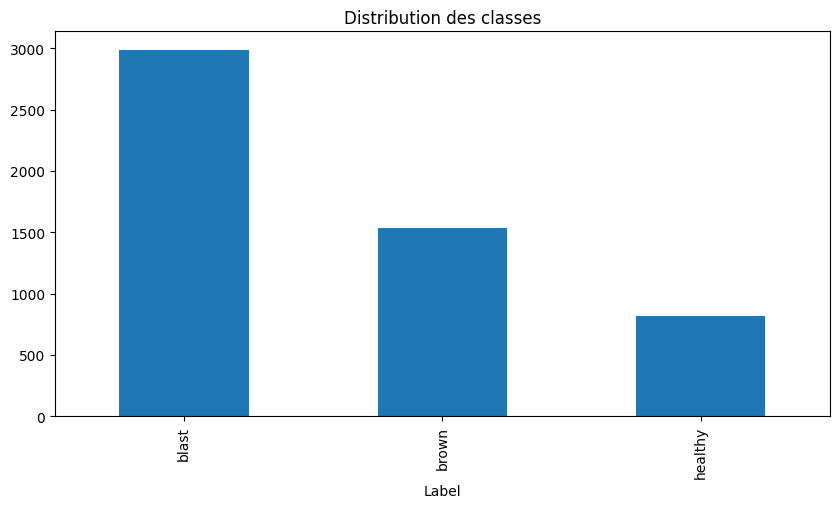

In [9]:
# Exploration des données
plt.figure(figsize=(10, 5))
df['Label'].value_counts().plot(kind='bar', title='Distribution des classes')
plt.show()

In [10]:
# On va encoder nos variables et aussi faire une validation croisée en s'assurant que dans chaque bloc un certtain pourcentage de toutes les classes soient représentés

# Initialisation pour l'encodage 
encoder = LabelEncoder()
df['score'] = encoder.fit_transform(df['Label'])
df = df.reset_index()


# Spécifiez les proportions de classe désirées pour chaque bloc
proportions_classes = {'blast': 0.4, 'brown': 0.4, 'healthy': 0.2}

# Créer StratifiedKFold avec des proportions de classe personnalisées
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Créer une nouvelle colonne pour les blocs et l'initialiser à -1
df['fold'] = -1

for n, (train_index, valid_index) in enumerate(kf.split(df, df['score'])):
    # Obtenir la distribution des classes dans l'ensemble d'entraînement
    distribution_classes_entrainement = df.iloc[train_index]['score'].value_counts(normalize=True)

    # Initialiser la colonne de bloc à -1
    df.loc[valid_index, 'fold'] = n

    # Ajuster les affectations de bloc pour respecter les proportions de classe désirées
    for label, proportion in proportions_classes.items():
        # Calculer le nombre d'instances nécessaires pour la classe actuelle
        num_instances = int(proportion * len(valid_index))
        # Obtenir le nombre réel d'instances dans l'ensemble d'entraînement
        num_instances_reel = int(distribution_classes_entrainement[encoder.transform([label])[0]] * len(train_index))

        # Si le nombre réel d'instances est inférieur à celui requis, déplacer des instances du jeu de validation vers le jeu d'entraînement
        if num_instances_reel < num_instances:
            # Obtenir les indices des instances avec l'étiquette actuelle dans le jeu de validation
            indices_label = df.loc[valid_index][df['score'] == encoder.transform([label])[0]].index
            # Déplacer les instances excédentaires du jeu de validation vers le jeu d'entraînement
            df.loc[indices_label[:instances_excédentaires], 'fold'] = n - 1

# Vérifier la distribution des classes dans chaque bloc
for bloc in range(5):
    print(f"Bloc {bloc}:")
    print(df[df['fold'] == bloc]['score'].value_counts(normalize=True))
    print("="*30)

Bloc 0:
score
0    0.559925
1    0.286517
2    0.153558
Name: proportion, dtype: float64
Bloc 1:
score
0    0.559925
1    0.286517
2    0.153558
Name: proportion, dtype: float64
Bloc 2:
score
0    0.559925
1    0.286517
2    0.153558
Name: proportion, dtype: float64
Bloc 3:
score
0    0.558989
1    0.287453
2    0.153558
Name: proportion, dtype: float64
Bloc 4:
score
0    0.558989
1    0.287453
2    0.153558
Name: proportion, dtype: float64


In [11]:
# df.to_csv(r'folds.csv')

In [12]:
# Vérifions si les images dans dont les Id sont dans le jeu de donnees Test et Train sont bien dans le repertoire image 

def verifier_correspondances(repertoire_images, chemin_fichier_csv):

    df = pd.read_csv(chemin_fichier_csv)

    # Liste des noms de fichiers dans le répertoire d'images
    noms_fichiers_images = set(os.listdir(repertoire_images))

    # Liste des noms de fichiers dans le CSV
    noms_fichiers_csv = set(df['Image_id'].tolist())

    # Vérifier si tous les noms de fichiers dans le CSV sont présents dans le répertoire d'images
    noms_manquants = noms_fichiers_csv - noms_fichiers_images

    if not noms_manquants:
        print(f"Tous les noms de fichiers du CSV sont présents dans le répertoire d'images.")
    else:
        print(f"Certains noms de fichiers du CSV ne sont pas présents dans le répertoire d'images:")
        print(noms_manquants)

# les chémins 
repertoire_images = '/kaggle/input/hussen1/Images'
chemin_fichier_train = '/kaggle/input/dossier/Train.csv'
chemin_fichier_test = '/kaggle/input/dossier/Test.csv'

# Vérifions pour le Jeu de donnees Train
verifier_correspondances(repertoire_images, chemin_fichier_train)

# Vérifions pour le jeu de donnees Test 
verifier_correspondances(repertoire_images, chemin_fichier_test)

Tous les noms de fichiers du CSV sont présents dans le répertoire d'images.
Tous les noms de fichiers du CSV sont présents dans le répertoire d'images.


In [13]:
# Fonction pour fixer les graines aléatoires dans différents modules

def set_everything(seed=42):
    
    # Fixer la graine du générateur de nombres pseudo-aléatoires de Python
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    # Fixer la graine du générateur de nombres aléatoires de NumPy
    np.random.seed(seed)
    
    # Fixer la graine du générateur de nombres aléatoires de PyTorch (CPU)
    torch.manual_seed(seed)
    
    # Fixer la graine du générateur de nombres aléatoires de PyTorch
    torch.cuda.manual_seed(seed)
    
    # Assurer la déterministicité des opérations de convolution de PyTorch sur GPU (si CUDA est disponible)
    torch.backends.cudnn.deterministic = True

# Appeler la fonction avec une graine par défaut de 42
set_everything()

In [14]:
# Définission d'une classe personnalisée Dataset en utilisant la classe Dataset de PyTorch.

class Dataset(Dataset):
    def __init__(self, image, file, mode, fold, h, w, transform=None):
        self.image = image
        self.w = w
        self.h = h
        self.transform = transform
        if mode == 'train':
            self.file = pd.read_csv(file)[pd.read_csv(file)['fold'] != fold].reset_index(drop=True)
        else:
            self.file = pd.read_csv(file)[pd.read_csv(file)['fold'] == fold].reset_index(drop=True)

    def __len__(self):
        return self.file.shape[0]

    def __getitem__(self, index):
        img_id = str(self.file['Image_id'][index])

        # Vérifier si 'Image_id' est une valeur valide
        if pd.notna(img_id):
            img_path = os.path.join(self.image, img_id)

            # Vérifier si le fichier existe avant de tenter de l'ouvrir
            if os.path.exists(img_path):
                image = np.array(Image.open(img_path).convert('RGB'))
            else:
                # Gérer le cas où le fichier n'existe pas
                image = np.zeros((self.h, self.w, 3), dtype=np.uint8)

            if self.transform is not None:
                augmentations = self.transform(image=image)
                image = augmentations['image']

            y = self.file['score'][index]
            if y == 1:
                y = [1, 0, 0]
            elif y == 2:
                y = [0, 1, 0]
            else:
                y = [0, 0, 1]

            return image, torch.tensor(y)

        else:
            # Gérer le cas où 'Image_id' est manquant ou égal à NaN
            image = np.zeros((self.h, self.w, 3), dtype=np.uint8)
            y = [0, 0, 0]

            return image, torch.tensor(y)

In [15]:
# Taux d'apprentissage (learning rate) pour l'optimiseur
LR = 1e-4

# Taille du lot d'entraînement (batch size)
BS = 32

# Nombre d'époques d'entraînement
NE = 5 
# Hauteur des images d'entrée
H = 192

# Largeur des images d'entrée
W = 224

# Chemin vers le répertoire contenant les images
IMG = r'/kaggle/input/hussen1/Images'

# Chemin vers le fichier CSV contenant les informations sur les plis (folds)
FILE = r'/kaggle/input/dossier/folds.csv'


In [16]:
def get_loaders(image, file, fold, h, w, bs, train_transform, val_transform, pin_memory=True):
    """
    Fonction pour obtenir les loaders d'entraînement et de validation.

    Parameters:
        image (str): Chemin vers le dossier contenant les images.
        file (str): Chemin vers le fichier CSV contenant les informations sur les images.
        fold (int): Numéro du pli pour la validation croisée.
        h (int): Hauteur des images après redimensionnement.
        w (int): Largeur des images après redimensionnement.
        bs (int): Taille du lot (batch size).
        train_transform (albumentations.Compose): Transformations d'augmentation pour l'entraînement.
        val_transform (albumentations.Compose): Transformations pour la validation.
        pin_memory (bool): Indique si l'utilisation de la mémoire GPU doit être activée.

    Returns:
        DataLoader: Loader d'entraînement.
        DataLoader: Loader de validation.
    """
    # Crée des instances de Dataset pour les ensembles d'entraînement et de validation
    train_ds = Dataset(image=image, file=file, mode='train', fold=fold, w=w, h=h, transform=train_transform)
    val_ds = Dataset(image=image, file=file, mode='val', fold=fold, w=w, h=h, transform=val_transform)

    # Crée des loaders d'entraînement et de validation
    train_loader = DataLoader(train_ds, batch_size=bs, pin_memory=pin_memory, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=bs, pin_memory=pin_memory, shuffle=False)

    return train_loader, val_loader

# Transformations d'augmentation de données
normalize = A.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.255],
    max_pixel_value=255.0
)

train_transform = A.Compose([
    A.Resize(width=W, height=H),
    A.HorizontalFlip(p=0.6),
    A.VerticalFlip(p=0.4),
    A.Rotate(limit=40),
    normalize,
    ToTensorV2()
], is_check_shapes=False)

val_transform = A.Compose([
    A.Resize(width=W, height=H),
    normalize,
    ToTensorV2()
], is_check_shapes=False)

Dans la suite on va effectuer une comparaison entre trois modèles sur nos données : EfficientNet, ResNetModel, DenseNetModel.
    
1. **EfficientNet** :

* Caractéristique principale : Conçu pour optimiser la performance et l'efficacité en ajustant simultanément la largeur, la profondeur, et la résolution des couches du réseau.

* Évolutivité : Les modèles EfficientNet sont évolués en utilisant un paramètre de mise à l'échelle (compound scaling) qui garantit un équilibre entre la largeur, la profondeur et la résolution du réseau.

2. **ResNet (Residual Networks)** :

* Caractéristique principale : Introduit des connexions résiduelles qui permettent un flux direct d'informations à travers les couches du réseau, facilitant l'apprentissage profond en évitant les problèmes de disparition du gradient.

* Architecture résiduelle : Les blocs résiduels, ou "residual blocks", contiennent des connexions skip (shortcuts) qui bypassent une ou plusieurs couches, facilitant l'apprentissage profond.
3. **DenseNet (Densely Connected Convolutional Networks)** :

* Caractéristique principale : Propose une architecture dense dans laquelle chaque couche reçoit des informations de toutes les couches précédentes dans un bloc.

* Connectivité dense : Les blocs dans DenseNet sont reliés de manière dense, ce qui signifie que chaque couche reçoit des entrées non seulement de la couche précédente mais aussi de toutes les couches précédentes dans le bloc.

Dans la suite on choisira le modele qui minimisera le critère suivant '**Average Validation Loss Across Folds**' qui se réfère à la moyenne des pertes de validation sur plusieurs plis (folds) lors de l'évaluation d'un modèle d'apprentissage automatique.

In [17]:
class Net(nn.Module):
    def __init__(self, net_version):
        """
        Initialise le modèle avec EfficientNet et une couche linéaire de classification.

        Parameters:
            net_version (str): Version d'EfficientNet à utiliser.
        """
        super(Net, self).__init__()

        # Crée une instance d'EfficientNet pré-entraînée avec la version spécifiée
        self.eff = EfficientNet.from_pretrained('efficientnet-' + net_version)

        # Nombre de classes de sortie (modifiable en fonction des besoins)
        num_classes = 3
        
        # Récupère les dimensions de sortie d'EfficientNet
        in_features = self.eff._fc.in_features
        
        # Ajuste la couche linéaire pour correspondre à la sortie d'EfficientNet
        self.out = nn.Linear(in_features, num_classes)

    def forward(self, x):
        """
        Méthode de propagation avant pour passer les données à travers le modèle.

        Parameters:
            x (torch.Tensor): Image en entrée.

        Returns:
            torch.Tensor: Sortie du modèle après la classification.
        """
        # Passe l'image à travers EfficientNet pour extraire des caractéristiques
        x = self.eff.extract_features(x)
        
        # Ajuste les dimensions de la sortie pour correspondre à la couche linéaire
        x = F.adaptive_avg_pool2d(x, (1, 1))
        
        # Aplatit les dimensions de la sortie
        x = x.view(x.size(0), -1)
        
        # Applique la couche linéaire pour la classification
        return self.out(x)
    
    

class ResNetModel(nn.Module):
    
    def __init__(self):
        super(ResNetModel, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(512, 3)

    def forward(self, x):
        return self.resnet(x)

    
    
class DenseNetModel(nn.Module):
    
    def __init__(self):
        super(DenseNetModel, self).__init__()
        self.densenet = models.densenet121(pretrained=True)
        self.densenet.classifier = nn.Linear(1024, 3)

    def forward(self, x):
        return self.densenet(x)
    
    
class ResNet50Model(nn.Module):
    
    def __init__(self):
        super(ResNet50Model, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        self.resnet50.fc = nn.Linear(2048, 3)  # Modifiez le nombre de classes en fonction de vos besoins

    def forward(self, x):
        return self.resnet50(x)



# Exemple d'utilisation de la classe Net avec des données factices
x = torch.rand(4, 3, 224, 192)
m = Net('b1')
output = m(x)

# Affiche la sortie du modèle
print(output)

# Exemple d'utilisation de la classe ResNetModel avec des données factices
x_resnet = torch.rand(4, 3, 224, 192)
model_resnet = ResNetModel()
output_resnet = model_resnet(x_resnet)

# Affiche la sortie du modèle ResNet
print(output_resnet)

# Exemple d'utilisation de la classe DenseNetModel avec des données factices
x_densenet = torch.rand(4, 3, 224, 192)
model_densenet = DenseNetModel()
output_densenet = model_densenet(x_densenet)

# Affiche la sortie du modèle DenseNet
print(output_densenet)

# Exemple d'utilisation de la classe ResNet50Model avec des données factices
x_resnet50 = torch.rand(4, 3, 224, 192)
model_resnet50 = ResNet50Model()
output_resnet50 = model_resnet50(x_resnet50)

# Affiche la sortie du modèle ResNet-50
print(output_resnet50)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 191MB/s]


Loaded pretrained weights for efficientnet-b1
tensor([[-0.0844,  0.0075, -0.0946],
        [-0.1246, -0.0200,  0.0722],
        [ 0.0498, -0.1421,  0.0633],
        [ 0.0647,  0.2464, -0.0761]], grad_fn=<AddmmBackward0>)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 56.3MB/s]


tensor([[ 0.2226,  1.1428,  0.0379],
        [ 0.3751,  0.5580,  0.0209],
        [ 0.1871,  0.7454, -0.9581],
        [ 0.0580,  0.0209, -0.2995]], grad_fn=<AddmmBackward0>)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 70.6MB/s]


tensor([[-0.1991,  0.1075,  0.9738],
        [-0.1627,  0.1010,  0.5397],
        [ 0.2687, -0.1025,  0.7099],
        [ 0.1645, -0.4954,  0.5661]], grad_fn=<AddmmBackward0>)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 227MB/s] 


tensor([[ 0.4944, -0.2541,  0.0648],
        [ 0.3693, -0.4306,  0.0884],
        [ 0.2106, -0.2750,  0.2913],
        [ 0.1085, -0.2752,  0.0355]], grad_fn=<AddmmBackward0>)


Notre test a reussi avec nos différents modèles.

In [18]:
def check_acc(loader, model, loss_fn):
    """
    Fonction pour calculer la perte moyenne sur un ensemble de données (loader).

    Parameters:
        loader (torch.utils.data.DataLoader): DataLoader pour l'ensemble de données.
        model (torch.nn.Module): Modèle à évaluer.
        loss_fn (torch.nn.Module): Fonction de perte à utiliser pour le calcul de la perte.

    Returns:
        torch.Tensor: La perte moyenne sur l'ensemble de données.
    """
    l = 0
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to('cuda').to(torch.float32)
            y = y.to('cuda').to(torch.float32)
            p = model(x)
            l += loss_fn(p, y)
        average_loss = l / len(loader)
        print(average_loss)
    model.train()
    return average_loss

def save_checkpoint(state, filename):
    """
    Fonction pour sauvegarder un checkpoint du modèle et de l'optimiseur.

    Parameters:
        state (dict): Dictionnaire contenant l'état du modèle et de l'optimiseur.
        filename (str): Nom du fichier pour sauvegarder le checkpoint.
    """
    print('--› Saving Checkpoint')
    torch.save(state, filename)

In [19]:
# Fonction d'entraînement avec AMP (Automatic Mixed Precision)
def train_fn(loader, model, optimizer, loss_fn, scaler):
    """
    Fonction d'entraînement utilisant la précision mixte (AMP).

    Parameters:
        loader (DataLoader): DataLoader contenant les données d'entraînement.
        model (torch.nn.Module): Modèle de réseau de neurones à entraîner.
        optimizer (torch.optim.Optimizer): Optimiseur utilisé pour mettre à jour les poids du modèle.
        loss_fn (torch.nn.Module): Fonction de perte utilisée pour calculer la perte.
        scaler (torch.cuda.amp.GradScaler): GradScaler d'AMP pour ajuster la précision lors de la rétropropagation.

    Returns:
        None
    """
    # Itérer sur le loader avec une barre de progression
    for x, y in tqdm(loader, desc="Training"):
        # Déplacer les données sur le GPU (s'il est disponible) et les convertir en float32
        x = x.to('cuda').to(torch.float32)
        y = y.to('cuda').to(torch.float32)

        # Forward (calcul des prédictions et de la perte)
        with torch.cuda.amp.autocast():
            scores = model(x)
            loss = loss_fn(scores, y.float())

        # Backward (rétropropagation des gradients)
        optimizer.zero_grad()
        # Utilisation de scaler pour effectuer la rétropropagation des gradients à une précision mixte
        scaler.scale(loss).backward()
        # Mise à jour des poids du modèle avec l'optimiseur
        scaler.step(optimizer)
        # Mise à jour du scaler pour la prochaine itération
        scaler.update()

Dans la suite, on effectue une boucle d'entraînement sur 5 plis (cross-validation) pour trois modèles différents (ResNet, EfficientNet, DenseNet). Pour chaque pli, les modèles sont entraînés et les pertes de validation moyennes sont calculées. Ensuite, les courbes des pertes de validation moyennes et des taux d'erreur sont tracées pour les trois modèles à travers les plis, permettant une comparaison visuelle de leurs performances.

----------------------------------------------- Fold: 0
Loaded pretrained weights for efficientnet-b1
----------------------------------------------- Epoch: 0


100%|██████████| 17/17 [00:05<00:00,  2.89it/s]


tensor(0.6021, device='cuda:0')


100%|██████████| 17/17 [00:02<00:00,  7.94it/s]


tensor(0.8832, device='cuda:0')


100%|██████████| 17/17 [00:02<00:00,  7.85it/s]


tensor(0.4167, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  9.48it/s]


tensor(0.5033, device='cuda:0')
--› Saving Checkpoint
--› Saving Checkpoint
--› Saving Checkpoint
--› Saving Checkpoint
----------------------------------------------- Epoch: 1


100%|██████████| 17/17 [00:01<00:00,  8.57it/s]


tensor(0.2717, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  8.63it/s]


tensor(0.6446, device='cuda:0')


100%|██████████| 17/17 [00:02<00:00,  8.43it/s]


tensor(0.2937, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  8.78it/s]


tensor(0.2566, device='cuda:0')
--› Saving Checkpoint
--› Saving Checkpoint
--› Saving Checkpoint
--› Saving Checkpoint
----------------------------------------------- Epoch: 2


100%|██████████| 17/17 [00:01<00:00,  8.91it/s]


tensor(0.5268, device='cuda:0')


100%|██████████| 17/17 [00:02<00:00,  8.01it/s]


tensor(0.4404, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  8.59it/s]


tensor(0.2371, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  9.38it/s]


tensor(0.2831, device='cuda:0')
--› Saving Checkpoint
--› Saving Checkpoint
----------------------------------------------- Epoch: 3


100%|██████████| 17/17 [00:01<00:00,  9.20it/s]


tensor(0.2513, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  8.88it/s]


tensor(0.3891, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  9.23it/s]


tensor(0.2435, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00, 10.04it/s]


tensor(0.2348, device='cuda:0')
--› Saving Checkpoint
--› Saving Checkpoint
--› Saving Checkpoint
----------------------------------------------- Epoch: 4


100%|██████████| 17/17 [00:01<00:00,  8.75it/s]


tensor(0.2087, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  8.62it/s]


tensor(0.2921, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  8.60it/s]


tensor(0.1873, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  9.56it/s]


tensor(0.2119, device='cuda:0')
--› Saving Checkpoint
--› Saving Checkpoint
--› Saving Checkpoint
--› Saving Checkpoint
----------------------------------------------- Fold: 1
Loaded pretrained weights for efficientnet-b1
----------------------------------------------- Epoch: 0


100%|██████████| 17/17 [00:02<00:00,  8.16it/s]


tensor(0.4417, device='cuda:0')


100%|██████████| 17/17 [00:02<00:00,  7.81it/s]


tensor(0.9552, device='cuda:0')


100%|██████████| 17/17 [00:02<00:00,  7.03it/s]


tensor(0.4497, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  8.68it/s]


tensor(0.4320, device='cuda:0')
--› Saving Checkpoint
--› Saving Checkpoint
--› Saving Checkpoint
--› Saving Checkpoint
----------------------------------------------- Epoch: 1


100%|██████████| 17/17 [00:01<00:00,  9.09it/s]


tensor(0.3965, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  8.67it/s]


tensor(0.6570, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  8.84it/s]


tensor(0.3609, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  9.22it/s]


tensor(0.3056, device='cuda:0')
--› Saving Checkpoint
--› Saving Checkpoint
--› Saving Checkpoint
--› Saving Checkpoint
----------------------------------------------- Epoch: 2


100%|██████████| 17/17 [00:01<00:00,  9.07it/s]


tensor(0.3316, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  9.18it/s]


tensor(0.5396, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  9.11it/s]


tensor(0.3008, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  9.48it/s]


tensor(0.2993, device='cuda:0')
--› Saving Checkpoint
--› Saving Checkpoint
--› Saving Checkpoint
--› Saving Checkpoint
----------------------------------------------- Epoch: 3


100%|██████████| 17/17 [00:01<00:00,  9.35it/s]


tensor(0.3190, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  8.77it/s]


tensor(0.4094, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  9.13it/s]


tensor(0.2488, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  9.19it/s]


tensor(0.2765, device='cuda:0')
--› Saving Checkpoint
--› Saving Checkpoint
--› Saving Checkpoint
--› Saving Checkpoint
----------------------------------------------- Epoch: 4


100%|██████████| 17/17 [00:01<00:00,  8.93it/s]


tensor(0.3470, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  8.99it/s]


tensor(0.3025, device='cuda:0')


100%|██████████| 17/17 [00:02<00:00,  8.39it/s]


tensor(0.2770, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  9.61it/s]


tensor(0.3121, device='cuda:0')
--› Saving Checkpoint
----------------------------------------------- Fold: 2
Loaded pretrained weights for efficientnet-b1
----------------------------------------------- Epoch: 0


100%|██████████| 17/17 [00:02<00:00,  8.32it/s]


tensor(0.4126, device='cuda:0')


100%|██████████| 17/17 [00:02<00:00,  8.45it/s]


tensor(0.8470, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  8.87it/s]


tensor(0.4099, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  9.36it/s]


tensor(0.3124, device='cuda:0')
--› Saving Checkpoint
--› Saving Checkpoint
--› Saving Checkpoint
--› Saving Checkpoint
----------------------------------------------- Epoch: 1


100%|██████████| 17/17 [00:01<00:00,  8.75it/s]


tensor(0.3359, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  8.66it/s]


tensor(0.6380, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  8.74it/s]


tensor(0.2922, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  9.12it/s]


tensor(0.2812, device='cuda:0')
--› Saving Checkpoint
--› Saving Checkpoint
--› Saving Checkpoint
--› Saving Checkpoint
----------------------------------------------- Epoch: 2


100%|██████████| 17/17 [00:01<00:00,  9.00it/s]


tensor(0.2676, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  9.10it/s]


tensor(0.4490, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  8.50it/s]


tensor(0.2302, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  9.73it/s]


tensor(0.2521, device='cuda:0')
--› Saving Checkpoint
--› Saving Checkpoint
--› Saving Checkpoint
--› Saving Checkpoint
----------------------------------------------- Epoch: 3


100%|██████████| 17/17 [00:01<00:00,  9.32it/s]


tensor(0.2559, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  8.88it/s]


tensor(0.3667, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  8.90it/s]


tensor(0.2330, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  9.72it/s]


tensor(0.2475, device='cuda:0')
--› Saving Checkpoint
--› Saving Checkpoint
--› Saving Checkpoint
----------------------------------------------- Epoch: 4


100%|██████████| 17/17 [00:03<00:00,  4.56it/s]


tensor(0.3214, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  8.83it/s]


tensor(0.3248, device='cuda:0')


100%|██████████| 17/17 [00:02<00:00,  7.95it/s]


tensor(0.1925, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  9.11it/s]


tensor(0.2628, device='cuda:0')
--› Saving Checkpoint
--› Saving Checkpoint
----------------------------------------------- Fold: 3
Loaded pretrained weights for efficientnet-b1
----------------------------------------------- Epoch: 0


100%|██████████| 17/17 [00:02<00:00,  8.28it/s]


tensor(0.4782, device='cuda:0')


100%|██████████| 17/17 [00:03<00:00,  4.82it/s]


tensor(0.9003, device='cuda:0')


100%|██████████| 17/17 [00:02<00:00,  6.41it/s]


tensor(0.4350, device='cuda:0')


100%|██████████| 17/17 [00:02<00:00,  8.50it/s]


tensor(0.3893, device='cuda:0')
--› Saving Checkpoint
--› Saving Checkpoint
--› Saving Checkpoint
--› Saving Checkpoint
----------------------------------------------- Epoch: 1


100%|██████████| 17/17 [00:01<00:00,  9.25it/s]


tensor(0.6243, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  9.22it/s]


tensor(0.7215, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  9.26it/s]


tensor(0.3132, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00, 10.07it/s]


tensor(0.3997, device='cuda:0')
--› Saving Checkpoint
--› Saving Checkpoint
----------------------------------------------- Epoch: 2


100%|██████████| 17/17 [00:01<00:00,  9.07it/s]


tensor(0.3680, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  8.51it/s]


tensor(0.4969, device='cuda:0')


100%|██████████| 17/17 [00:02<00:00,  8.45it/s]


tensor(0.2839, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  9.45it/s]


tensor(0.2259, device='cuda:0')
--› Saving Checkpoint
--› Saving Checkpoint
--› Saving Checkpoint
--› Saving Checkpoint
----------------------------------------------- Epoch: 3


100%|██████████| 17/17 [00:02<00:00,  8.29it/s]


tensor(0.3851, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  8.83it/s]


tensor(0.3639, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  8.77it/s]


tensor(0.2452, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  9.52it/s]


tensor(0.2142, device='cuda:0')
--› Saving Checkpoint
--› Saving Checkpoint
--› Saving Checkpoint
----------------------------------------------- Epoch: 4


100%|██████████| 17/17 [00:02<00:00,  8.22it/s]


tensor(0.3115, device='cuda:0')


100%|██████████| 17/17 [00:02<00:00,  8.50it/s]


tensor(0.3244, device='cuda:0')


100%|██████████| 17/17 [00:03<00:00,  5.61it/s]


tensor(0.2512, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  9.19it/s]


tensor(0.2527, device='cuda:0')
--› Saving Checkpoint
--› Saving Checkpoint
----------------------------------------------- Fold: 4
Loaded pretrained weights for efficientnet-b1
----------------------------------------------- Epoch: 0


100%|██████████| 17/17 [00:01<00:00,  8.88it/s]


tensor(0.4866, device='cuda:0')


100%|██████████| 17/17 [00:02<00:00,  7.92it/s]


tensor(0.8749, device='cuda:0')


100%|██████████| 17/17 [00:02<00:00,  8.44it/s]


tensor(0.4061, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  9.52it/s]


tensor(0.3341, device='cuda:0')
--› Saving Checkpoint
--› Saving Checkpoint
--› Saving Checkpoint
--› Saving Checkpoint
----------------------------------------------- Epoch: 1


100%|██████████| 17/17 [00:02<00:00,  7.83it/s]


tensor(0.3538, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  8.91it/s]


tensor(0.6945, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  8.93it/s]


tensor(0.2799, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  8.83it/s]


tensor(0.3025, device='cuda:0')
--› Saving Checkpoint
--› Saving Checkpoint
--› Saving Checkpoint
--› Saving Checkpoint
----------------------------------------------- Epoch: 2


100%|██████████| 17/17 [00:01<00:00,  8.85it/s]


tensor(0.3094, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  8.59it/s]


tensor(0.4644, device='cuda:0')


100%|██████████| 17/17 [00:02<00:00,  8.48it/s]


tensor(0.2174, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  9.49it/s]


tensor(0.2195, device='cuda:0')
--› Saving Checkpoint
--› Saving Checkpoint
--› Saving Checkpoint
--› Saving Checkpoint
----------------------------------------------- Epoch: 3


100%|██████████| 17/17 [00:02<00:00,  7.92it/s]


tensor(0.2272, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  8.57it/s]


tensor(0.3192, device='cuda:0')


100%|██████████| 17/17 [00:02<00:00,  7.90it/s]


tensor(0.2092, device='cuda:0')


100%|██████████| 17/17 [00:02<00:00,  8.29it/s]


tensor(0.2830, device='cuda:0')
--› Saving Checkpoint
--› Saving Checkpoint
--› Saving Checkpoint
----------------------------------------------- Epoch: 4


100%|██████████| 17/17 [00:02<00:00,  8.49it/s]


tensor(0.2420, device='cuda:0')


100%|██████████| 17/17 [00:02<00:00,  8.17it/s]


tensor(0.2774, device='cuda:0')


100%|██████████| 17/17 [00:02<00:00,  8.39it/s]


tensor(0.1948, device='cuda:0')


100%|██████████| 17/17 [00:01<00:00,  9.04it/s]


tensor(0.2464, device='cuda:0')
--› Saving Checkpoint
--› Saving Checkpoint


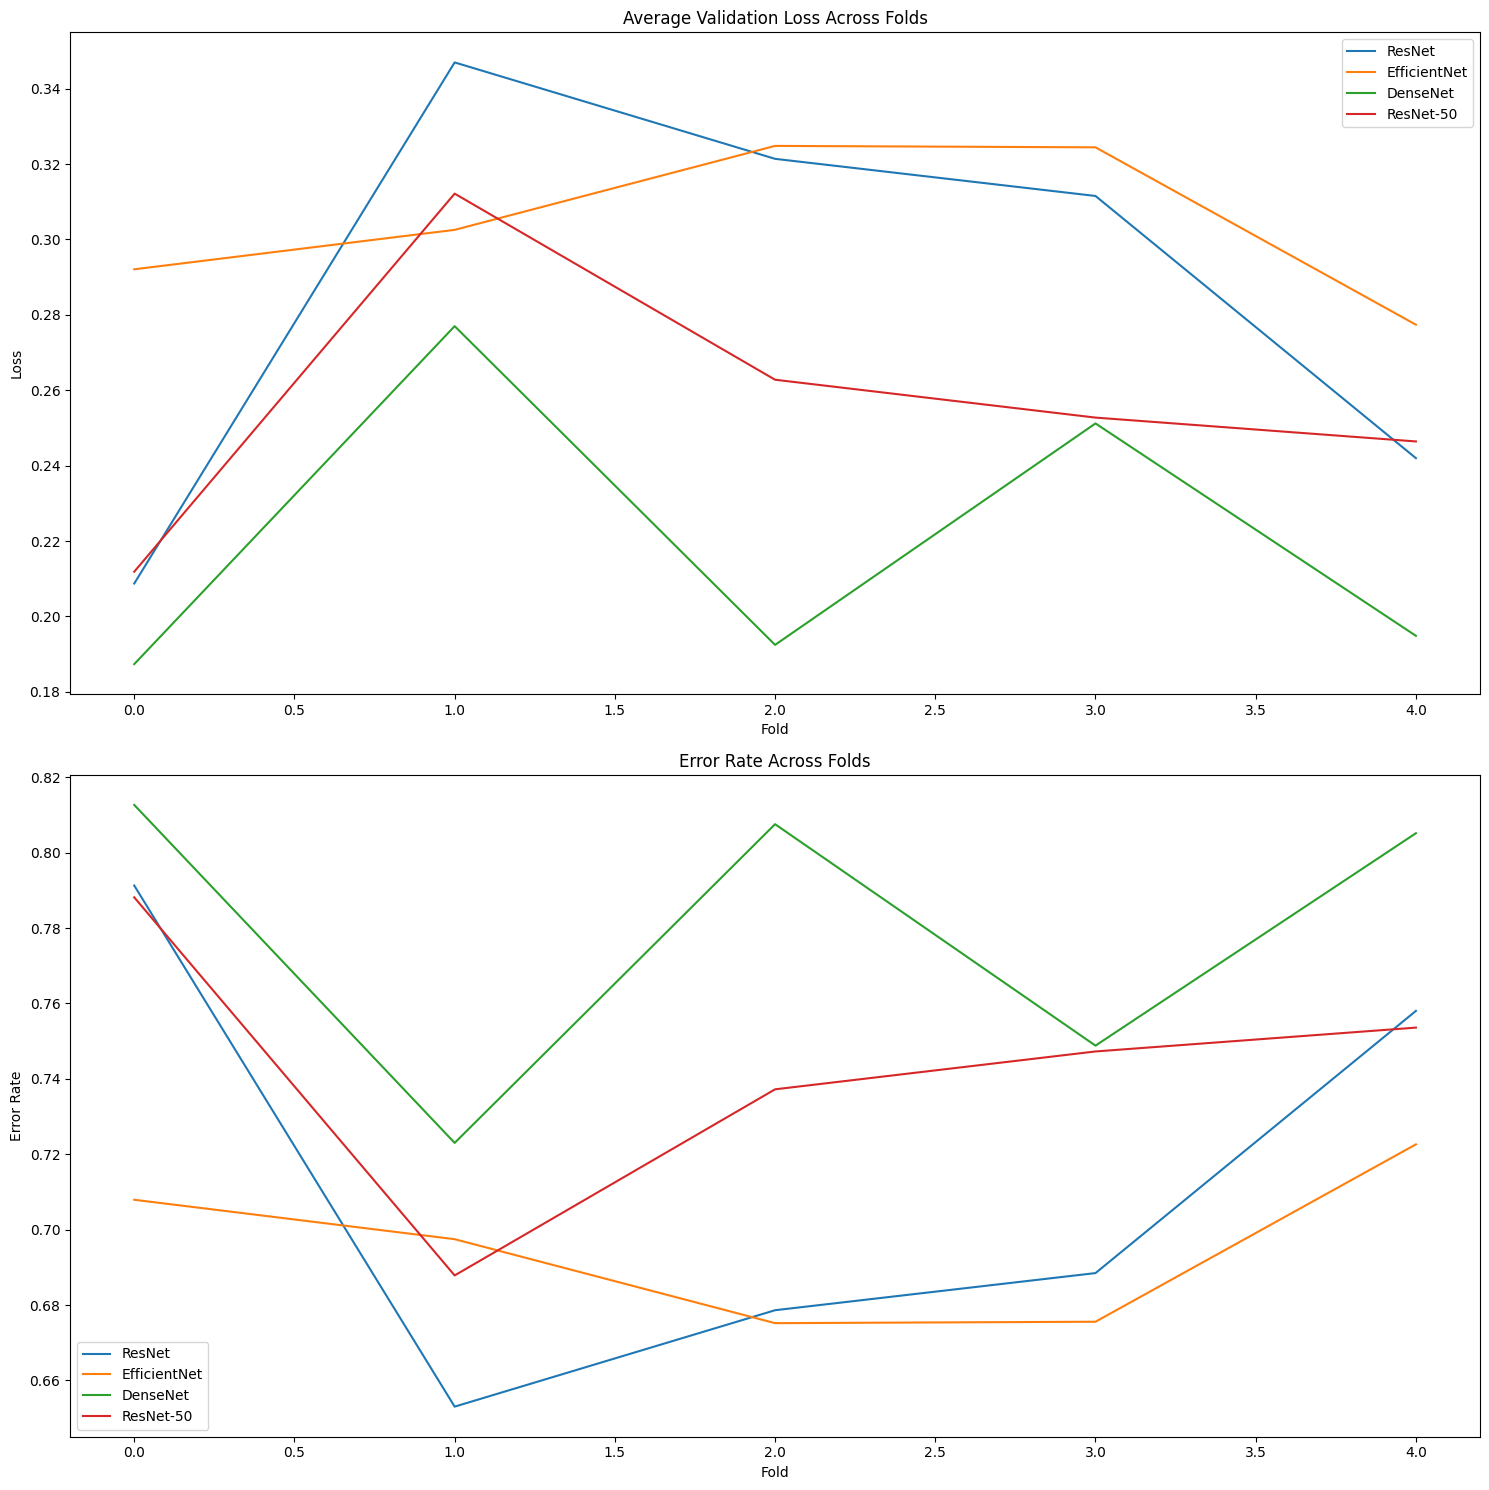

In [20]:
# Initialiser une liste pour stocker les moyennes des pertes de validation par fold
average_val_losses_resnet = []
average_val_losses_efficientnet = []
average_val_losses_densenet = []
average_val_losses_resnet50 = []


# Boucle d'entraînement sur 5 plis (cross-validation)
for fold in range(5): 
    print('----------------------------------------------- Fold: ' + str(fold))
    
    # Définition de la fonction de perte (Cross Entropy Loss)
    loss_fn = nn.CrossEntropyLoss()  
    
    # Initialisation du scaler pour la précision mixte (Automatic Mixed Precision)
    scaler = torch.cuda.amp.GradScaler()
    
    # Création d'une instance du modèle ResNet
    model_resnet = ResNetModel().to('cuda')
    optimizer_resnet = optim.Adam(model_resnet.parameters(), lr=LR)
    
    # Création d'une instance du modèle avec la version 'b1' d'EfficientNet
    model_efficientnet = Net('b1').to('cuda')  # Renommez la variable pour éviter les confusions
    optimizer_efficientnet = optim.Adam(model_efficientnet.parameters(), lr=LR)
    
    # Création d'une instance du modèle DenseNet
    model_densenet = DenseNetModel().to('cuda')
    optimizer_densenet = optim.Adam(model_densenet.parameters(), lr=LR)
    
    # Création d'une instance du modèle ResNet-50
    model_resnet50 = ResNet50Model().to('cuda')
    optimizer_resnet50 = optim.Adam(model_resnet50.parameters(), lr=LR)  


    # Obtention des loaders d'entraînement et de validation pour le pli courant
    train_loader, val_loader = get_loaders(
        IMG, FILE, fold, H, W, BS, train_transform, val_transform
    )

    l_efficientnet = float('inf')
    l_resnet = float('inf')
    l_densenet = float('inf')
    l_resnet50 = float('inf')
    
    # Initialiser une liste pour suivre les pertes de validation pour ce fold
    val_losses = []
    
    
    # Initialisation des variables pour l'arrêt anticipé
    early_stopping_resnet = {'patience': 5, 'counter': 0, 'best_loss': float('inf')}
    early_stopping_efficientnet = {'patience': 5, 'counter': 0, 'best_loss': float('inf')}
    early_stopping_densenet = {'patience': 5, 'counter': 0, 'best_loss': float('inf')}
    # Initialisation des variables pour l'arrêt anticipé
    early_stopping_resnet50 = {'patience': 5, 'counter': 0, 'best_loss': float('inf')}

    
    # Boucle d'entraînement sur plusieurs époques
    for epoch in range(NE):
        print('----------------------------------------------- Epoch: ' + str(epoch))
        
        # Entraînement du modèle ResNet
        train_fn(train_loader, model_resnet, optimizer_resnet, loss_fn, scaler)

        # Entraînement du modèle EfficientNet
        train_fn(train_loader, model_efficientnet, optimizer_efficientnet, loss_fn, scaler)

        # Entraînement du modèle DenseNet
        train_fn(train_loader, model_densenet, optimizer_densenet, loss_fn, scaler)
        
        # Entraînement du modèle ResNet-50
        train_fn(train_loader, model_resnet50, optimizer_resnet50, loss_fn, scaler)

        
        # Calcul de la perte sur le loader de validation pour chaque modèle
        val_loss_resnet = check_acc(val_loader, model_resnet, loss_fn)
        val_loss_efficientnet = check_acc(val_loader, model_efficientnet, loss_fn)
        val_loss_densenet = check_acc(val_loader, model_densenet, loss_fn)
        val_loss_resnet50 = check_acc(val_loader, model_resnet50, loss_fn)
        
        
        # Gestion de l'arrêt anticipé pour ResNet
        if val_loss_resnet < early_stopping_resnet['best_loss']:
            early_stopping_resnet['best_loss'] = val_loss_resnet
            early_stopping_resnet['counter'] = 0
        else:
            early_stopping_resnet['counter'] += 1

        if early_stopping_resnet['counter'] >= early_stopping_resnet['patience']:
            print("Arrêt anticipé pour ResNet.")
            break

        # Gestion de l'arrêt anticipé pour EfficientNet
        if val_loss_efficientnet < early_stopping_efficientnet['best_loss']:
            early_stopping_efficientnet['best_loss'] = val_loss_efficientnet
            early_stopping_efficientnet['counter'] = 0
        else:
            early_stopping_efficientnet['counter'] += 1

        if early_stopping_efficientnet['counter'] >= early_stopping_efficientnet['patience']:
            print("Arrêt anticipé pour EfficientNet.")
            break

        # Gestion de l'arrêt anticipé pour DenseNet
        if val_loss_densenet < early_stopping_densenet['best_loss']:
            early_stopping_densenet['best_loss'] = val_loss_densenet
            early_stopping_densenet['counter'] = 0
        else:
            early_stopping_densenet['counter'] += 1

        if early_stopping_densenet['counter'] >= early_stopping_densenet['patience']:
            print("Arrêt anticipé pour DenseNet.")
            break
        
        
        # Gestion de l'arrêt anticipé pour ResNet-50
        if val_loss_resnet50 < early_stopping_resnet50['best_loss']:
            early_stopping_resnet50['best_loss'] = val_loss_resnet50
            early_stopping_resnet50['counter'] = 0
        else:
            early_stopping_resnet50['counter'] += 1

        if early_stopping_resnet50['counter'] >= early_stopping_resnet50['patience']:
            print("Arrêt anticipé pour ResNet-50.")
            break

        
        

            
        # Sauvegarde du checkpoint du modèle ResNet si la perte est inférieure à la meilleure perte précédente
        if val_loss_resnet < l_resnet:
            l_resnet = val_loss_resnet
            checkpoint_resnet = {
                'state_dict': model_resnet.state_dict(),
                'optimizer': optimizer_resnet.state_dict()
            }
            save_checkpoint(checkpoint_resnet, filename='rice_disease_resnet' + str(fold) + '.pth.tar')

        # Sauvegarde du checkpoint du modèle EfficientNet si la perte est inférieure à la meilleure perte précédente
        if val_loss_efficientnet < l_efficientnet:
            l_efficientnet = val_loss_efficientnet
            checkpoint_efficientnet = {
                'state_dict': model_efficientnet.state_dict(),
                'optimizer': optimizer_efficientnet.state_dict()
            }
            save_checkpoint(checkpoint_efficientnet, filename='rice_disease_efficientnet' + str(fold) + '.pth.tar')

        # Sauvegarde du checkpoint du modèle DenseNet si la perte est inférieure à la meilleure perte précédente
        if val_loss_densenet < l_densenet:
            l_densenet = val_loss_densenet
            checkpoint_densenet = {
                'state_dict': model_densenet.state_dict(),
                'optimizer': optimizer_densenet.state_dict()
            }
            save_checkpoint(checkpoint_densenet, filename='rice_disease_densenet' + str(fold) + '.pth.tar')

            
            
        # Sauvegarde du checkpoint du modèle ResNet-50 si la perte est inférieure à la meilleure perte précédente
        if val_loss_resnet50 < l_resnet50:
            l_resnet50 = val_loss_resnet50
            checkpoint_resnet50 = {
                'state_dict': model_resnet50.state_dict(),
                'optimizer': optimizer_resnet50.state_dict()
            }
            save_checkpoint(checkpoint_resnet50, filename='rice_disease_resnet50' + str(fold) + '.pth.tar')

    # Calculer la moyenne des pertes de validation pour ResNet-50
    average_val_loss_resnet50 = torch.tensor([val_loss_resnet50.item()]).mean().item()
    average_val_losses_resnet50.append(average_val_loss_resnet50)
    
    
    # Calculer la moyenne des pertes de validation pour ResNet
    average_val_loss_resnet = torch.tensor([val_loss_resnet.item()]).mean().item()
    average_val_losses_resnet.append(average_val_loss_resnet)

    # Calculer la moyenne des pertes de validation pour EfficientNet
    average_val_loss_efficientnet = torch.tensor([val_loss_efficientnet.item()]).mean().item()
    average_val_losses_efficientnet.append(average_val_loss_efficientnet)

    # Calculer la moyenne des pertes de validation pour DenseNet
    average_val_loss_densenet = torch.tensor([val_loss_densenet.item()]).mean().item()
    average_val_losses_densenet.append(average_val_loss_densenet)

    
# Affichage des courbes demandées
plt.figure(figsize=(15, 15))

# Courbes pour valid_loss
plt.subplot(2, 1, 1)
plt.plot(average_val_losses_resnet, label='ResNet')
plt.plot(average_val_losses_efficientnet, label='EfficientNet')
plt.plot(average_val_losses_densenet, label='DenseNet')
plt.plot(average_val_losses_resnet50, label='ResNet-50')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.title('Average Validation Loss Across Folds')
plt.legend()

# Courbes pour error rate
plt.subplot(2, 1, 2)
plt.plot(1 - np.array(average_val_losses_resnet), label='ResNet')
plt.plot(1 - np.array(average_val_losses_efficientnet), label='EfficientNet')
plt.plot(1 - np.array(average_val_losses_densenet), label='DenseNet')
plt.plot(1- np.array(average_val_losses_resnet50), label='ResNet-50')
plt.xlabel('Fold')
plt.ylabel('Error Rate')
plt.title('Error Rate Across Folds')
plt.legend()

plt.tight_layout()
plt.show()


Au vu des différents schémas, je décide de choisir le modèles DensetNet

On passe maintenant à la prédiction des différentes classes des images dont les Id figurent dans les données de test 

In [23]:
# Charger le modèle entraîné
model = DenseNetModel().to('cuda')
model.load_state_dict(torch.load('/kaggle/working/rice_disease_densenet0.pth.tar')['state_dict'])
model.eval()

# Définir les transformations pour l'inférence
inference_transform = transforms.Compose([
    transforms.Resize((224, 192)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.255]),
])

# Charger le fichier Test.csv
test_df = pd.read_csv('/kaggle/input/dossier/Test.csv')

# Créer un DataFrame pour stocker les prédictions
predictions_df = pd.DataFrame(columns=['Image_id', 'blast', 'brown', 'healthy'])

# Prédire pour chaque image dans le fichier Test.csv
for index, row in test_df.iterrows():
    # Ignorer les images avec "_rgn.jpg" dans leur nom
    if "_rgn.jpg" in row['Image_id']:
        continue

    image_path = os.path.join('/kaggle/input/hussen1/Images', row['Image_id'])
    
    # Charger l'image et appliquer les transformations
    image = Image.open(image_path).convert('RGB')
    image = inference_transform(image)
    image = image.unsqueeze(0)

    # Déplacer les images sur cuda
    image = image.to('cuda')

    # Effectuer la prédiction
    with torch.no_grad():
        model.eval()
        output = model(image)

    # Appliquer la fonction softmax pour obtenir les probabilités
    probs = torch.nn.functional.softmax(output, dim=1)

    # Récupérer les probabilités pour chaque classe
    prob_blast = probs[0, 0].item()
    prob_brown = probs[0, 1].item()
    prob_healthy = probs[0, 2].item()

    # Créer un dictionnaire avec les valeurs à ajouter
    new_row = {
        'Image_id': row['Image_id'],
        'blast': prob_blast,
        'brown': prob_brown,
        'healthy': prob_healthy
    }

    # Ajouter la nouvelle ligne au DataFrame
    predictions_df.loc[len(predictions_df)] = new_row

# Sauvegarder les prédictions dans un fichier CSV
predictions_df.to_csv('/kaggle/working/predictions.csv', index=False)

test_df.to_csv('/kaggle/working/SampleSubmission.csv', columns=['Image_id'], index=False)
